In [1]:
import os
import yaml
import torch
import torchaudio.transforms as tfa_transforms
import models
import data
from nussl import STFTParams
import nussl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This code is very similar to the evaluation script.

# Put the trained path here:
train_path = '/home/andreas/HighResSeparation/output/musdb_toy/runs/f628b84344d5411e80aa6ea048259dd8'

model_path = os.path.join(train_path, "checkpoints/best.model.pth")

class Bunch():
    def __init__(self, d : dict):
        self.__dict__.update(d)

# This loads all the flags from training into a namespace.
with open(os.path.join(train_path, '.guild/attrs/flags')) as f:
    train_config = yaml.safe_load(f)
    train_namespace = Bunch(train_config)

separate = train_namespace.task == 'separation'
train_namespace.device = 'cuda:1'

model = models.HRNet(
    train_namespace.closure_key,
    4,
    pretrained=train_namespace.imagenet_pretrained,
    stft_params=STFTParams(window_length=train_namespace.window_length,
                           hop_length=train_namespace.hop_length,
                           window_type=train_namespace.window_type),
    head=train_namespace.task,
    stem=train_namespace.stem,
    audio_channels=1,
    skip=train_namespace.skip
).to(train_namespace.device)

model.load_state_dict(torch.load(model_path))

resampler = tfa_transforms.Resample(
    44_100,
    train_namespace.sample_rate
).to(train_namespace.device)

In [3]:
# Dataset
with open('data_conf/musdb_args.yml') as s:
    kwargs = yaml.safe_load(s)
kwargs['num_tracks'] = 1
train_dataset, _ = data.build_musdb(False, **kwargs)

Loading excerpt locations...: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]
/home/andreas/miniconda3/envs/hr/lib/python3.9/site-packages/nussl/core/audio_signal.py:1353: UserWarning: Shape of new audio_data does not match current audio_data.
  warnings.warn('Shape of new audio_data does not match current audio_data.')
Loading excerpt locations...: 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]
/home/andreas/miniconda3/envs/hr/lib/python3.9/site-packages/nussl/core/audio_signal.py:1353: UserWarning: Shape of new audio_data does not match current audio_data.
  warnings.warn('Shape of new audio_data does not match current audio_data.')


In [4]:
train_dataset.num_excerpts = 1
dataloader = iter(torch.utils.data.DataLoader(train_dataset, shuffle=False))

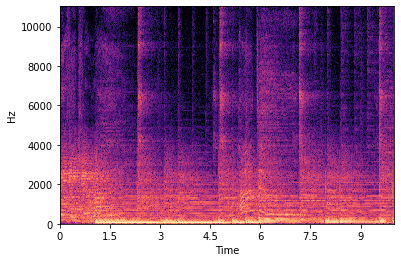

In [5]:
item = next(dataloader)
mix_audio = resampler(item['mix_audio'])
source_audio = resampler(item['source_audio'].permute(0, 1, 3, 2)).permute(0, 1, 3, 2)

audio_signal = nussl.AudioSignal(
    audio_data_array=mix_audio[0].cpu().numpy(),
    stft_params=model.stft_params,
    sample_rate=train_namespace.sample_rate
)
audio_signal.embed_audio()
audio_signal.stft()
nussl.core.utils.visualize_spectrogram(audio_signal)


In [6]:
output = model(mix_audio.to(train_namespace.device))

/home/andreas/miniconda3/envs/hr/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


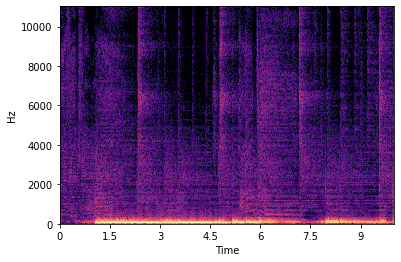

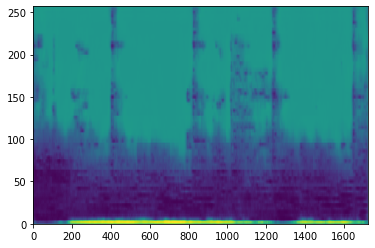

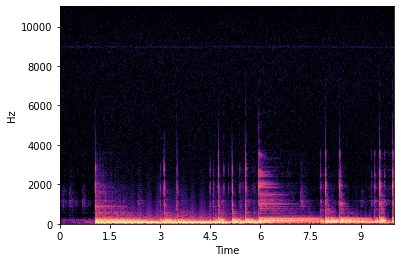

In [9]:
source_idx = 0
mask = output['masks'][0, ..., source_idx]
soft_mask = nussl.core.masks.SoftMask(mask.permute(1, 0, 2).detach().cpu().numpy())
est_source_signal = audio_signal.apply_mask(soft_mask)
est_source_signal.istft()

est_source_signal.embed_audio()
nussl.core.utils.visualize_spectrogram(est_source_signal)
plt.show()

plt.pcolormesh(soft_mask.mask[..., 0])
plt.show()

source_signal = nussl.AudioSignal(
    audio_data_array=source_audio[0, ..., source_idx].cpu().numpy(),
    stft_params=model.stft_params,
    sample_rate=train_namespace.sample_rate
)

source_signal.stft()

source_signal.embed_audio()
nussl.core.utils.visualize_spectrogram(source_signal)


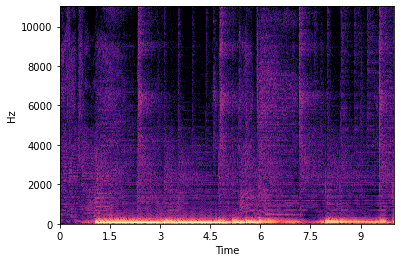

In [8]:
# Estimated audio
output_audio_signal = nussl.AudioSignal(
    audio_data_array=output['audio'][0, ..., 0].detach().cpu().numpy(),
    stft_params=model.stft_params,
    sample_rate=train_namespace.sample_rate
)
output_audio_signal.embed_audio()
output_audio_signal.stft()
nussl.core.utils.visualize_spectrogram(output_audio_signal)